#### Домашнее задание №7

Практическое задание:
- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат


In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

data = pd.read_csv("../../data/pima-indians-diabetes.data.csv", 
                    names=['pregnancies_count', 'glucose', 'arterial_pressure',
                           'th_skinfold_thickness', '2h_insulin', 'body_mass_index',
                           'diabetes_pedigree', 'age', 'diabetes'
                          ])
data.head()

,pregnancies_count,glucose,arterial_pressure,th_skinfold_thickness,2h_insulin,body_mass_index,diabetes_pedigree,age,diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   pregnancies_count      768 non-null    int64  
 1   glucose                768 non-null    int64  
 2   arterial_pressure      768 non-null    int64  
 3   th_skinfold_thickness  768 non-null    int64  
 4   2h_insulin             768 non-null    int64  
 5   body_mass_index        768 non-null    float64
 6   diabetes_pedigree      768 non-null    float64
 7   age                    768 non-null    int64  
 8   diabetes               768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


###### Набор данных диабета индейцев Пима
Набор данных о диабете индейцев пима включает прогнозирование возникновения диабета в течение 5 лет у индейцев пима с учетом медицинских данных.

Это бинарная (2-классная) задача классификации. Количество наблюдений для каждого класса не сбалансировано. Есть 768 наблюдений с 8 входными переменными и 1 выходной переменной. Считается, что пропущенные значения кодируются нулевыми значениями. Имена переменных следующие:

0. Количество раз беременных.
1. Концентрация глюкозы в плазме через 2 часа при оральном тесте на толерантность к глюкозе.
2. Диастолическое артериальное давление (мм рт. Ст.).
3. Толщина трехглавой кожной складки (мм).
4. 2-часовой сывороточный инсулин (мю Ед / мл).
5. Индекс массы тела (вес в кг / (рост в м) ^ 2).
6. Родословная функция диабета.
7. Возраст (годы).
8. Переменная класса (0 или 1).

In [3]:
target_name = 'diabetes'
data[target_name].value_counts()

0    500
1    268
Name: diabetes, dtype: int64

In [4]:
train = data.drop(target_name, 1)
target = data[target_name]

#разделим данные на train/test
x_train, x_test, y_train, y_test = train_test_split(
    train, target, test_size=0.2, random_state=7)

Соберем пайплайн

In [5]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]
    

    
continuous_columns = train.columns
final_transformers = list()
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('scaler', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))
    
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

In [6]:
import catboost as cb

pipeline = Pipeline([
    ('features',feats),
    ('classifier', cb.CatBoostClassifier()),
])

In [7]:
#обучим наш пайплайн
pipeline.fit(x_train, y_train, classifier__silent=True)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('pregnancies_count',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='pregnancies_count')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('glucose',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='glucose')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('arterial_pressure',
                                                 Pipeline(steps=[('selector',
   

Посчитаем MAE и коэффициент детерминации (R2)

In [8]:
predictions =  pipeline.predict(x_test)
 
mean_absolute_error(y_pred=predictions, y_true=y_test), r2_score(y_pred=predictions, y_true=y_test)

(0.19480519480519481, 0.164405860010852)

In [9]:
pd.DataFrame(
    pipeline[1].get_feature_importance(), 
    index=train.columns)\
.sort_values(0, ascending=False)

,0
glucose,21.439104
body_mass_index,18.806190
age,13.289736
diabetes_pedigree,12.782631
pregnancies_count,9.077806
arterial_pressure,8.370581
2h_insulin,8.234420
th_skinfold_thickness,7.999532


In [10]:
from sklearn.inspection import permutation_importance
r = permutation_importance(pipeline, x_test, y_test,
                            n_repeats=30,
                            random_state=0)

In [11]:
for i in r.importances_mean.argsort()[::-1]:
    print(f"{continuous_columns[i]:<8} "
    f"{r.importances_mean[i]:.3f}"
    f" +/- {r.importances_std[i]:.3f}")

glucose  0.148 +/- 0.027
body_mass_index 0.038 +/- 0.015
age      0.032 +/- 0.019
diabetes_pedigree 0.024 +/- 0.014
2h_insulin 0.019 +/- 0.012
pregnancies_count 0.015 +/- 0.016
arterial_pressure 0.013 +/- 0.013
th_skinfold_thickness -0.003 +/- 0.015


Топ-4 в данном случае совпал с "родным" анализатором от катбуста

### SHAP

In [12]:
import shap

# load JS visualization code to notebook
shap.initjs()

from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [13]:
model = cb.CatBoostClassifier()
model.fit(x_train, y_train, silent=True)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_train)

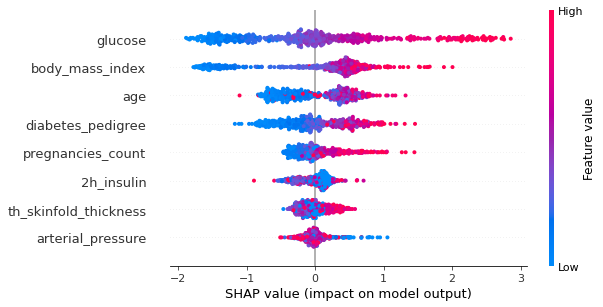

In [14]:
# summarize the effects of all the features
shap.summary_plot(shap_values, x_train)

Заметна хорошая связь (в основном прямопропорциональная) значений признаков с таргетом

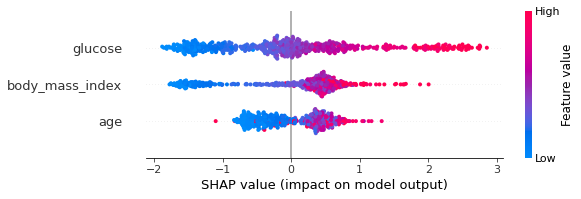

In [15]:
shap.summary_plot(shap_values, x_train, max_display=3) # top-10% маловат

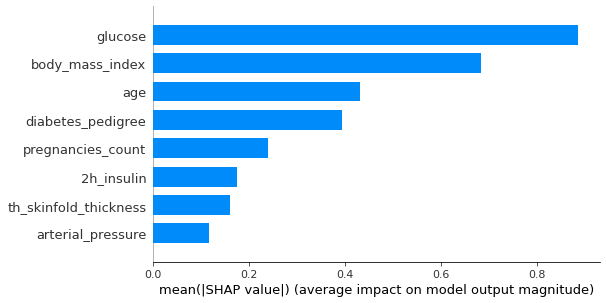

In [16]:
shap.summary_plot(shap_values, x_train, plot_type="bar")

In [17]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], x_train.iloc[0,:])

несмотря на ожирение 2 степени, против появления диабета говорят хорошая наследственность, нормальные уровень глюкозы и артериальное давление. Но, все-таки видно, что опасность есть

In [18]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[1,:], x_train.iloc[1,:])

Одно только ожирение 3 степени перевешивает все положительные факторы, даже не смотря на уровень глюкозы меньший, чем у предыдущего

In [19]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[2,:], x_train.iloc[2,:])

Здесь просто однозначный ответ на основании глюкозы и наследственности

In [20]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[5,:], x_train.iloc[5,:])

Нормальный уровень глюкозы сильно перевешивает ожирение 2 степени в даннгом случае